# Fraud detection

In [1]:
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score,f1_score,precision_score
#Visualization
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score


In [3]:
from scipy.io.arff import loadarff 
from sklearn.preprocessing import LabelEncoder
raw_data1 = loadarff('base_validacao_10.arff')
raw_data2 = loadarff('base_desenv_10.arff')
df=pd.concat([pd.DataFrame(raw_data1[0]), pd.DataFrame(raw_data2[0])])
df.rename(columns={'flag_fraude_cat': 'Class'}, inplace=True)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Label encode the 'Class' column
df['Class'] = label_encoder.fit_transform(df['Class'])
tr_data = df
X = tr_data.drop(['Class'], axis = 'columns')
Label_Data = tr_data['Class']
y=tr_data['Class']

In [4]:
df.describe()

,mcc_cat,mcc_ant_cat,cep_cat,cep_ant_cat,valor_trans_cat,valor_trans_ant_cat,pos_entry,lim_cred_cat,bandeira_cat,variante_cat,score_cat,tp_pessoa_cat,trans_nacional_cat,qtde_parc_cat,velocidade_cat,dif_score_cat,trans_limit_cat,Class
count,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000,41647.000000
mean,10.903594,6.631066,3.903498,2.287608,4.992148,3.362643,3.834394,5.897376,2.348597,2.015295,0.627632,0.983144,0.004898,1.210195,3.365092,2.933561,0.069945,0.037434
std,6.264281,7.300314,2.441080,2.648559,2.434398,2.713027,3.159835,2.430889,1.717720,0.835296,1.699113,0.128733,0.069817,0.466728,1.706885,0.984673,0.399696,0.189824
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,0.000000,2.000000,0.000000,3.000000,1.000000,2.000000,4.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,3.000000,0.000000,0.000000
50%,9.000000,6.000000,4.000000,1.000000,5.000000,2.000000,2.000000,6.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,2.000000,3.000000,0.000000,0.000000
75%,15.000000,12.000000,6.000000,4.000000,7.000000,5.000000,9.000000,8.000000,5.000000,3.000000,0.000000,1.000000,0.000000,1.000000,5.000000,3.000000,0.000000,0.000000
max,32.000000,32.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,5.000000,5.000000,9.000000,1.000000,1.000000,3.000000,7.000000,5.000000,9.000000,1.000000


In [5]:
df.shape

(41647, 18)

In [6]:
selected_vars =['mcc_cat', 'mcc_ant_cat', 'cep_cat', 'cep_ant_cat', 'valor_trans_cat','valor_trans_ant_cat', 'pos_entry', 'lim_cred_cat', 'bandeira_cat','variante_cat', 'score_cat', 'tp_pessoa_cat', 'trans_nacional_cat','qtde_parc_cat', 'velocidade_cat', 'dif_score_cat', 'trans_limit_cat']

In [7]:
df1=df[selected_vars]
Target=df['Class']
df.drop('Class',axis=1, inplace=True)

In [8]:
df1.head()

,mcc_cat,mcc_ant_cat,cep_cat,cep_ant_cat,valor_trans_cat,valor_trans_ant_cat,pos_entry,lim_cred_cat,bandeira_cat,variante_cat,score_cat,tp_pessoa_cat,trans_nacional_cat,qtde_parc_cat,velocidade_cat,dif_score_cat,trans_limit_cat
0,9.0,22.0,3.0,3.0,6.0,6.0,2.0,6.0,2.0,3.0,0.0,1.0,0.0,1.0,7.0,1.0,0.0
1,22.0,9.0,3.0,3.0,7.0,6.0,2.0,6.0,2.0,3.0,0.0,1.0,0.0,1.0,6.0,4.0,0.0
2,22.0,22.0,3.0,3.0,7.0,7.0,2.0,6.0,2.0,3.0,0.0,1.0,0.0,1.0,4.0,4.0,0.0
3,6.0,0.0,3.0,0.0,8.0,1.0,2.0,9.0,2.0,3.0,0.0,1.0,0.0,1.0,2.0,3.0,0.0
4,6.0,6.0,3.0,3.0,3.0,6.0,2.0,7.0,2.0,3.0,0.0,1.0,0.0,1.0,2.0,4.0,0.0


# outlier

## OneClassSVM

In [9]:
from sklearn.svm import OneClassSVM

In [10]:
df1_fraud=df1[Target==1]
df1_normal=df1[Target==0]
df1_fraud.shape,df1_normal.shape

((1559, 17), (40088, 17))

In [11]:
clf = OneClassSVM()
res = clf.fit_predict(df1_fraud)
np.unique(res)

array([-1,  1], dtype=int64)

In [12]:
df1_normal['Class']=0
df1_fraud['Class']=res

In [13]:
frames = [df1_normal, df1_fraud]
result = pd.concat(frames)

In [14]:
osvm_res=result[result['Class']!=-1]
osvm_out=result[result['Class']==-1]
result[result['Class']==-1].shape

(775, 18)

In [15]:
osvm_t=pd.DataFrame(osvm_res['Class'])
osvm_res.drop(['Class'],axis=1,inplace=True)
osvm_ot=pd.DataFrame(osvm_out['Class'])
osvm_out.drop(['Class'],axis=1,inplace=True)

# Balancing

In [16]:
from imblearn.over_sampling import SMOTE 

Mean ACC:  0.98629871547661  Mean precision:  0.668075260943559  Mean Recall:  0.5702369015712171  Mean F1:  0.6139769375143901  Mean AUC:  0.7823248288603619


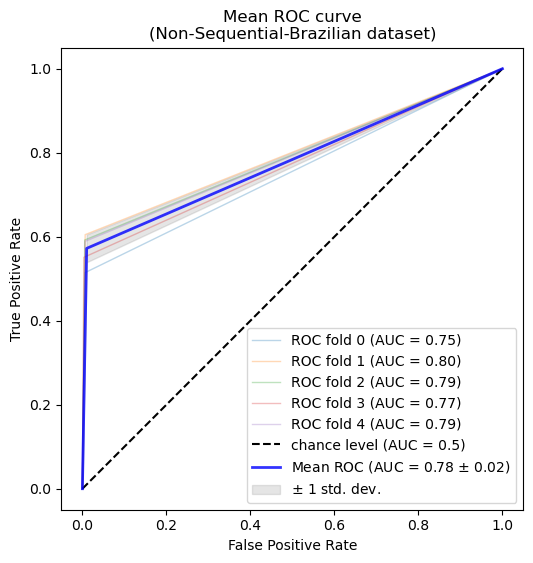

In [17]:
from sklearn.metrics import accuracy_score
from statistics import mean
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

kf = KFold(n_splits=5, shuffle = True,random_state=0)
X=osvm_res.copy()
X.reset_index(drop=True,inplace=True)
y=osvm_t.copy()
y.reset_index(drop=True,inplace=True)
f1=[]
acc=[]
recall=[]
precision=[]
AUC=[]
prs = []
aucs = []
k=0
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(6, 6))
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    ros = SMOTE(random_state=0,sampling_strategy=0.0806315789)
    X_resampled, y_resampled = ros.fit_resample(X_train,y_train)
    X_resampled=pd.concat([X_resampled, osvm_out])
    y_resampled=pd.concat([y_resampled, osvm_ot])
    y_resampled[y_resampled==-1]=1
    clf = LGBMClassifier(colsample_bytree=0.85, is_unbalance=False, learning_rate=0.01,num_iterations=1000,
               max_bin=100, max_depth=16, metric='f1', min_child_samples=100,
               min_child_weight=0,n_estimators=5000,
               num_leaves=1000, random_state=0,
                subsample_freq=0,verbose=-1)
    clf.fit(X_resampled,y_resampled)
    preds = clf.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=1)
    AUC.append(metrics.auc(fpr, tpr))
    f1.append(f1_score(y_test, preds))
    acc.append(accuracy_score(y_test, preds))
    recall.append(recall_score(y_test,preds))
    precision.append(precision_score(y_test, preds))
    viz = RocCurveDisplay.from_predictions(
        y_test,
        preds,
        name=f"ROC fold {k}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    k+=1
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
print("Mean ACC: ",mean(acc)," Mean precision: ",mean(precision)," Mean Recall: ",mean(recall)," Mean F1: ",mean(f1)," Mean AUC: ",mean(AUC))
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
title=f"Mean ROC curve\n(Non-Sequential-Brazilian dataset)",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()